## Predict Bike Sharing Demand with AutoGluon

In [23]:
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import autogluon.core as ag
from autogluon.core.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from autogluon.core.models import GreedyWeightedEnsembleModel

In [2]:
sns.set_theme(style='whitegrid')

### Explore dataset

In [3]:
train = pd.read_csv('train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
test = pd.read_csv('test.csv')
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
submission = pd.read_csv('sampleSubmission.csv')

### Feature engineering

#### Change the dtype of datetime column and extracting month, day, hour, and weekday

In [8]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

In [9]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

#### Setting the dtype to category for categorical features

In [10]:
categorical_features = ['month', 'hour', 'weekday', 'season', 'weather', 'holiday', 'workingday']
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

#### Removing redundant features

In [11]:
train = train.drop(['datetime', 'casual', 'registered'], axis=1)
test = test.drop('datetime', axis=1)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   month       10886 non-null  category
 10  hour        10886 non-null  category
 11  weekday     10886 non-null  category
dtypes: category(7), float64(3), int64(2)
memory usage: 501.9 KB


### Visualization

<AxesSubplot:xlabel='season', ylabel='count'>

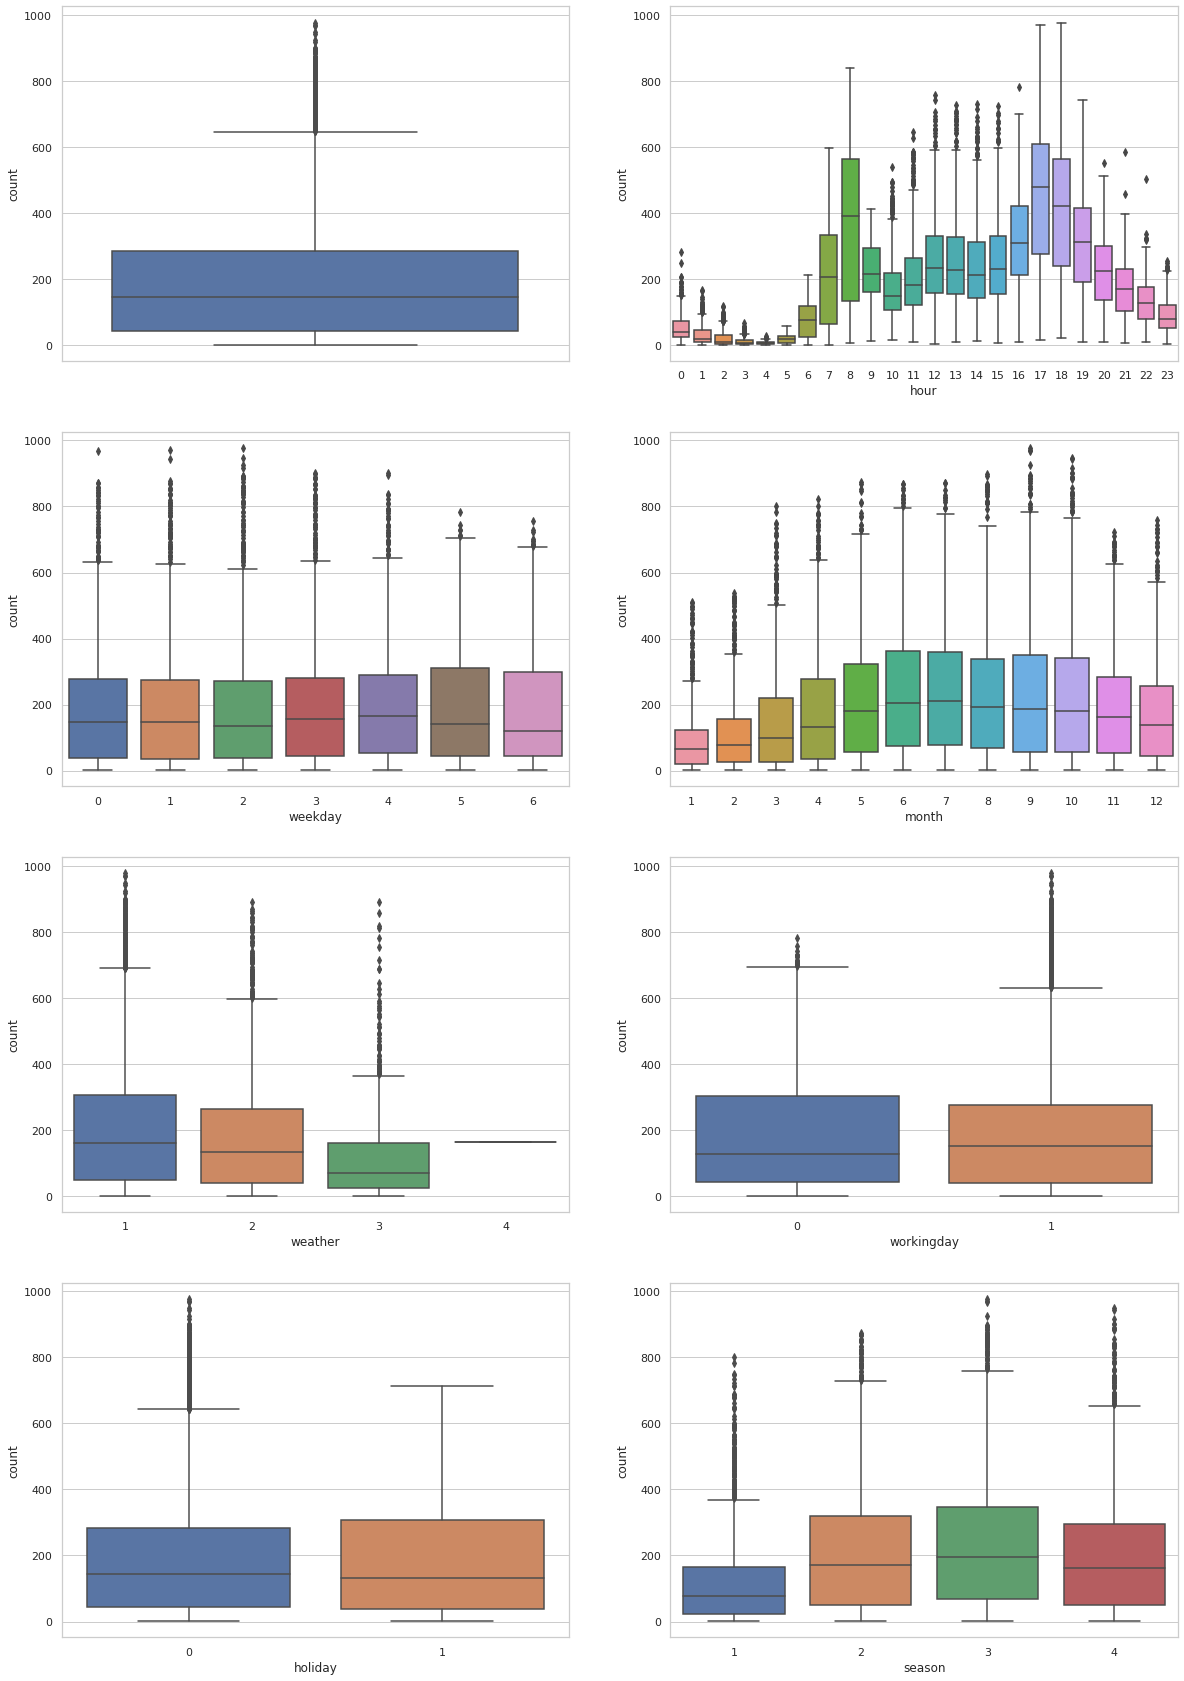

In [13]:
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(20, 30)
sns.boxplot(data=train, y='count', ax=axes[0][0])
sns.boxplot(data=train, x='hour', y='count', ax=axes[0][1])
sns.boxplot(data=train, x='weekday', y='count', ax=axes[1][0])
sns.boxplot(data=train, x='month', y='count', ax=axes[1][1])
sns.boxplot(data=train, x='weather', y='count', ax=axes[2][0])
sns.boxplot(data=train, x='workingday', y='count', ax=axes[2][1])
sns.boxplot(data=train, x='holiday', y='count', ax=axes[3][0])
sns.boxplot(data=train, x='season', y='count', ax=axes[3][1])

#### Outliers removal

In [14]:
train = train[(np.abs(stats.zscore(train)) < 3).all(axis=1)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10341 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10341 non-null  category
 1   holiday     10341 non-null  category
 2   workingday  10341 non-null  category
 3   weather     10341 non-null  category
 4   temp        10341 non-null  float64 
 5   atemp       10341 non-null  float64 
 6   humidity    10341 non-null  int64   
 7   windspeed   10341 non-null  float64 
 8   count       10341 non-null  int64   
 9   month       10341 non-null  category
 10  hour        10341 non-null  category
 11  weekday     10341 non-null  category
dtypes: category(7), float64(3), int64(2)
memory usage: 557.5 KB


<AxesSubplot:xlabel='season', ylabel='count'>

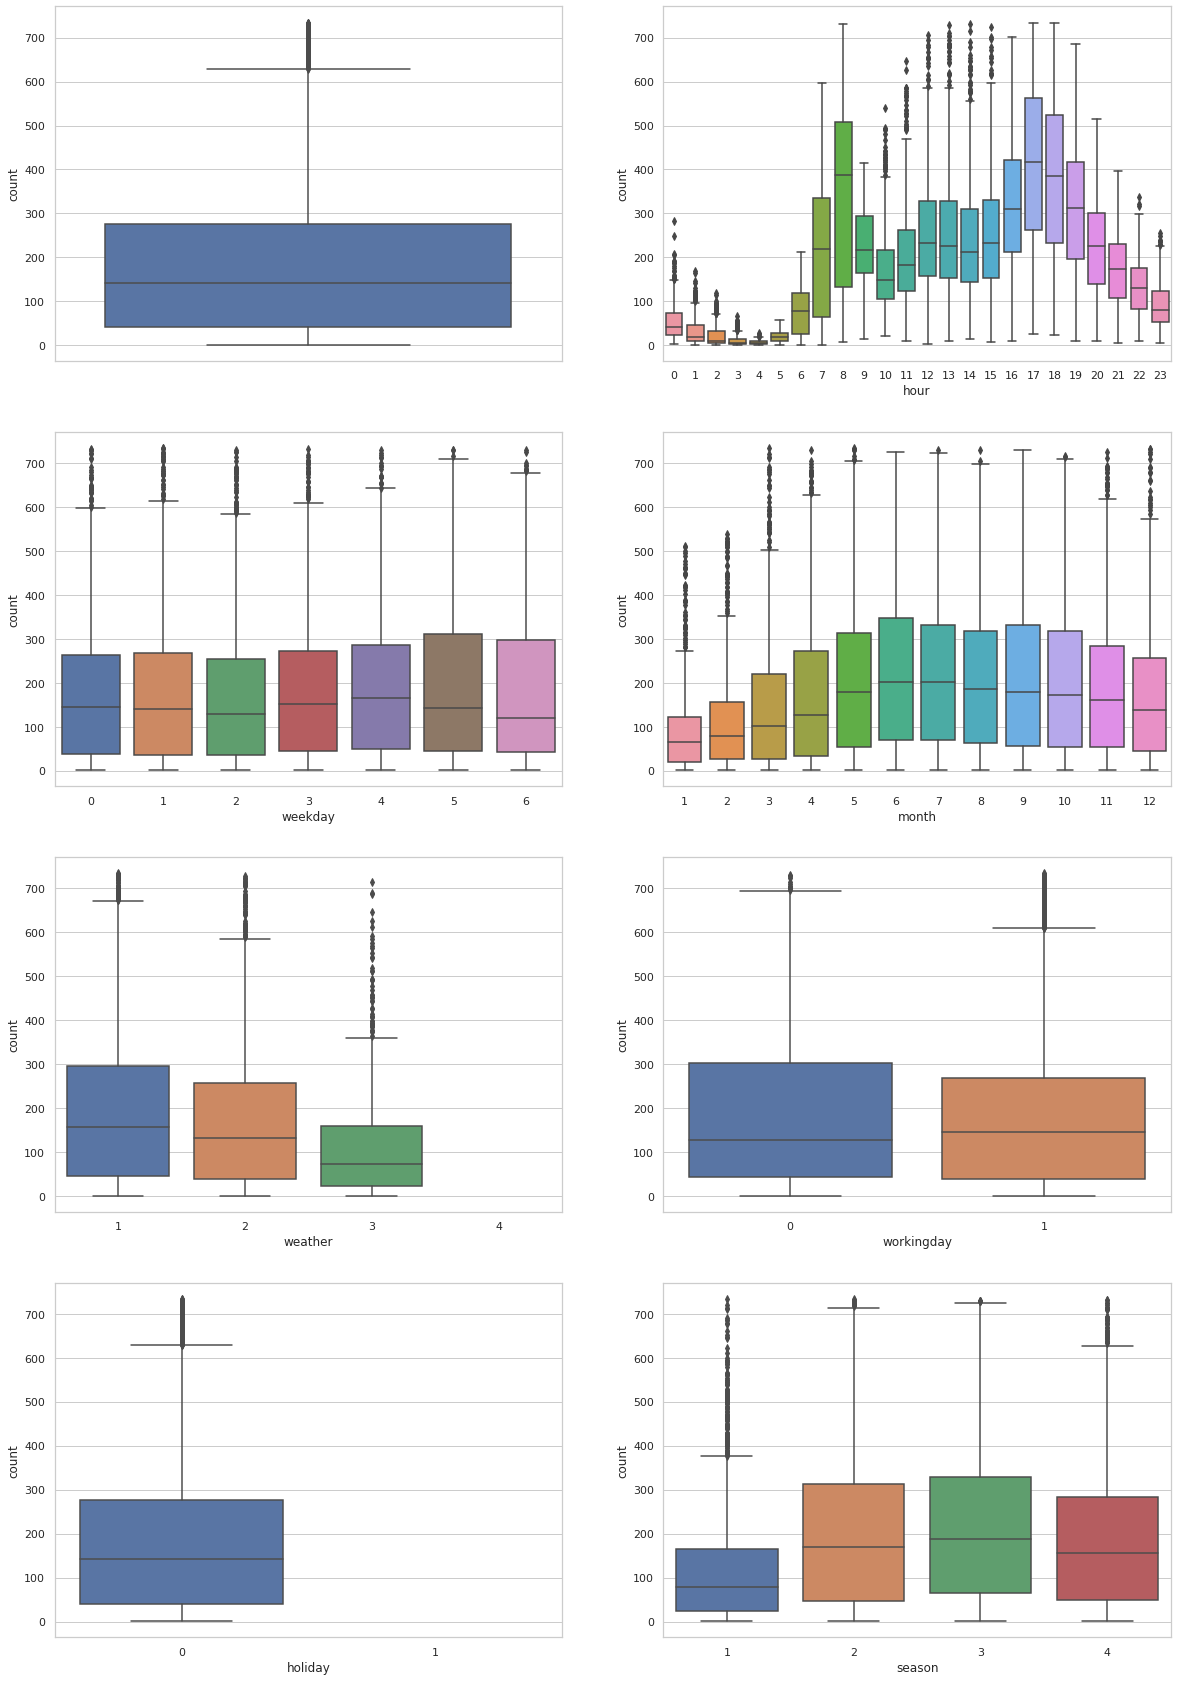

In [15]:
fig, axes = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(20, 30)
sns.boxplot(data=train, y='count', ax=axes[0][0])
sns.boxplot(data=train, x='hour', y='count', ax=axes[0][1])
sns.boxplot(data=train, x='weekday', y='count', ax=axes[1][0])
sns.boxplot(data=train, x='month', y='count', ax=axes[1][1])
sns.boxplot(data=train, x='weather', y='count', ax=axes[2][0])
sns.boxplot(data=train, x='workingday', y='count', ax=axes[2][1])
sns.boxplot(data=train, x='holiday', y='count', ax=axes[3][0])
sns.boxplot(data=train, x='season', y='count', ax=axes[3][1])

In [ ]:
predictor_new_features = TabularPredictor(
    label='count',
    eval_metric='rmse'
).fit(
    train_data=train,
    time_limit=20*60,
    presets="best_quality",
    num_bag_folds=7,
    num_stack_levels=3
)

In [ ]:
predictor_new_features.fit_summary()

In [ ]:
predictions = predictor_new_features.predict(test)

In [ ]:
predictions[predictions < 0] = 0

In [ ]:
submission_new_features = submission
submission_new_features["count"] = predictions
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

### Hyperparameter tuning

In [27]:
train_hpo, val_hpo = train_test_split(train, test_size=0.2, random_state=0)

In [32]:
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 100,  # number of training epochs (controls training time of NN models)
#     'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
#     'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
#     'layers': ag.space.Categorical([100], [1000], [200, 100], [300, 200, 100]),  # each choice for categorical hyperparameter 'layers' corresponds to list of sizes for each NN layer to use
#     'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 1000,  # number of boosting rounds (controls training time of GBM models)
#     'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN': nn_options,
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 20*60
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using Bayesian optimization routine with a local scheduler

hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

# excluded_model_types = ['KNN', 'NN', 'custom']

In [35]:
predictor_new_hpo = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train,
#     tuning_data=val_hpo,
    time_limit=time_limit,
    presets="best_quality",
#     auto_stack=True,
    num_bag_folds=7,
    num_bag_sets=1,
    num_stack_levels=2,
#     excluded_model_types=excluded_model_types,
#     hyperparameters = {'NN': {'num_epochs': 10}, 'GBM': {'num_boost_round': 100}}
#     hyperparameters=hyperparameters,
#     hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20211231_031513/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20211231_031513/"
AutoGluon Version:  0.3.1
Train Data Rows:    10341
Train Data Columns: 11
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7272.23 MB
	Train Data (Original)  Memory Usage: 0.4 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting Cate

[1000]	train_set's rmse: 39.1711	valid_set's rmse: 58.5859


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.4664	valid_set's rmse: 55.6913


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 38.9679	valid_set's rmse: 56.2094
[2000]	train_set's rmse: 31.3871	valid_set's rmse: 55.6159
[3000]	train_set's rmse: 26.7172	valid_set's rmse: 55.6005


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.3617	valid_set's rmse: 54.6623


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.3876	valid_set's rmse: 55.8358
[2000]	train_set's rmse: 31.896	valid_set's rmse: 55.4093


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.0773	valid_set's rmse: 58.3944
[2000]	train_set's rmse: 31.5475	valid_set's rmse: 58.0086
[3000]	train_set's rmse: 26.868	valid_set's rmse: 57.8344


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 39.3947	valid_set's rmse: 56.8929
[2000]	train_set's rmse: 31.6547	valid_set's rmse: 56.216


	-56.1751	 = Validation score   (root_mean_squared_error)
	13.06s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 519.16s of the 1185.93s of remaining time.
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 27.8019	valid_set's rmse: 57.773


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 27.8769	valid_set's rmse: 54.7114


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.3116	valid_set's rmse: 54.2568


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.1107	valid_set's rmse: 55.4818


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 28.3448	valid_set's rmse: 57.0004


/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 27.7799	valid_set's rmse: 56.8734


	-55.7862	 = Validation score   (root_mean_squared_error)
	6.74s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 511.97s of the 1178.73s of remaining time.
	-59.8799	 = Validation score   (root_mean_squared_error)
	1.35s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 510.1s of the 1176.86s of remaining time.
	-57.0196	 = Validation score   (root_mean_squared_error)
	115.6s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 394.25s of the 1061.01s of remaining time.
	-58.9074	 = Validation score   (root_mean_squared_error)
	1.13s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 392.59s of the 1059.36s of remaining time.
	-53.9218	 = Validation score   (root_mean_squared_error)
	43.37s	 = Training   runtime
	0.16s	 = Validat

	-54.64	 = Validation score   (root_mean_squared_error)
	49.67s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 394.82s of the 617.28s of remaining time.
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbo

Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 222.75s of remaining time.
	-52.5257	 = Validation score   (root_mean_squared_error)
	0.25s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L3 models ...
Fitting model: LightGBMXT_BAG_L3 ... Training model for up to 222.49s of the 222.48s of remaining time.
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be

	Ran out of time, early stopping on iteration 34. Best iteration is:
	[34]	train_set's rmse: 71.7144	valid_set's rmse: 74.9248
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 35. Best iteration is:
	[35]	train_set's rmse: 69.9313	valid_set's rmse: 76.5295
/home/soheil/ml/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	Ran out of time, early stopping on iteration 37. 

In [36]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.525677      12.993572   860.008180                0.000376           0.251624            3       True         22
1      WeightedEnsemble_L4  -52.642262      13.944038  1064.374990                0.000367           0.211942            4       True         31
2          CatBoost_BAG_L3  -52.819804      13.243943   976.809536                0.065032          16.751745            3       True         26
3      WeightedEnsemble_L2  -52.882840       1.010291   180.364698                0.000352           0.237538            2       True         12
4     ExtraTreesMSE_BAG_L2  -53.212539       6.846714   525.530452                0.352251           1.945668            2       True         17
5          CatBoost_BAG_L2  -53.328666       6.550308   535.933098  

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiT

In [37]:
predictions_new_hpo = predictor_new_hpo.predict(test)

In [38]:
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [39]:
submission_new_hpo = submission
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 95.9kB/s]
Successfully submitted to Bike Sharing Demand

In [41]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2021-12-31 03:36:24  new features with hyperparameters  complete  0.46800      0.46800       
submission_new_hpo.csv       2021-12-29 06:23:08  new features with hyperparameters  complete  0.47510      0.47510       
submission_new_hpo.csv       2021-12-29 05:44:38  new features with hyperparameters  complete  0.48197      0.48197       


### Creating plots and table for report

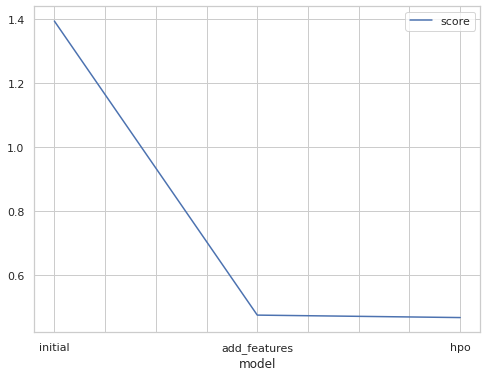

In [42]:
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [1.39413, 0.47568, 0.46800]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [49]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "time": [600, 1200, 1200],
    "presets": ["best_quality", "best_quality", "best_quality"],
    "num_bag_folds": ['Default', 'Default', 7],
    "num_bag_sets": ['Default', 'Default', 1],
    "num_stack_levels": ['Default', 'Default', 2],
    "score": [1.39413, 0.47568, 0.46800]
}).to_markdown(index=False, tablefmt="grid")

'+--------------+--------+--------------+-----------------+----------------+--------------------+---------+\n| model        |   time | presets      | num_bag_folds   | num_bag_sets   | num_stack_levels   |   score |\n+==============+========+==============+=================+================+====================+=========+\n| initial      |    600 | best_quality | Default         | Default        | Default            | 1.39413 |\n+--------------+--------+--------------+-----------------+----------------+--------------------+---------+\n| add_features |   1200 | best_quality | Default         | Default        | Default            | 0.47568 |\n+--------------+--------+--------------+-----------------+----------------+--------------------+---------+\n| hpo          |   1200 | best_quality | 7               | 1              | 2                  | 0.468   |\n+--------------+--------+--------------+-----------------+----------------+--------------------+---------+'